# Shift + Enter untuk Run (Run semua cell secara berurutan) atau bisa klik Runtime -> Run all
# Jika ingin predict gambar ct scan lain, klik Runtime -> Factory Reset Runtime

# Download Dependencies & Import Libraries

In [ ]:
!pip install pydicom

import keras
import numpy as np
import cv2
import os
import keras.backend as k
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pydicom as dicom
from pydicom.filebase import DicomBytesIO

# [INPUT] Setup and Auth Google Drive (Login with preferred Google Account)

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

# Setup Model

In [ ]:
LOCAL_PATH = '/content/'
ROOT_FOLDER_ID = '1okOw8sfCV5ONo4eHdfR8eAGrf9ZBwu17' 

import io
import re
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.errors import HttpError

FOLDER_MIMETYPE = 'application/vnd.google-apps.folder'
PREFIX_MATCH = r'^(\w+( \w+)*)\/'

def clean_path(path):
    return re.sub("\/$", "", path)

def download(service, unit_id, file_path, mutable_file_path = None):
    if os.path.isfile(file_path):
        print("{} already existed".format(file_path))
        return True

    if mutable_file_path is None:
        mutable_file_path = file_path

    mutable_file_path = clean_path(mutable_file_path)

    query = "'{}' in parents".format(unit_id)
    results = service.files().list(fields="nextPageToken, files(id, name, mimeType, version)", q=query).execute()

    items = results.get('files', [])
    # print(mutable_file_path, items)
    
    is_folder_unit = False
    folder_name = None
    if '/' in mutable_file_path:
        is_folder_unit = True
        # print(mutable_file_path)
        folder_name = re.findall(PREFIX_MATCH, mutable_file_path)[0][0]
        # print(folder_name)

    for item in items:
        if is_folder_unit and item['name'] == folder_name and item['mimeType'] == FOLDER_MIMETYPE:
            return download(service, item['id'], file_path, re.sub(PREFIX_MATCH, '', mutable_file_path))
        elif item['name'] == mutable_file_path:
            file = service.files().get(fileId=item['id'], fields='id, name, mimeType, version').execute()
            request = service.files().get_media(fileId=item['id'])
            fh = io.BytesIO()
            downloader = MediaIoBaseDownload(fh, request)
            done = False

            try:
                while done is False:
                    status, done = downloader.next_chunk()

                folder_path = os.path.dirname(file_path)
                # print(folder_path)
                # print(file_path)
                # if not os.path.isdir(folder_path):
                #     os.makedirs(folder_path)

                with io.open(file_path, 'wb') as f:
                    fh.seek(0)
                    f.write(fh.read())

                print("{} has been downloaded".format(file_path))
                return True
            except HttpError as error:
                print(error)
                if error.resp.status == 416:
                    # Create empty file
                    open(file_path, 'a').close()
                    echo("Create empty file {}".format(file_path))
                break
        
    raise ValueError("Invalid path")

# Download Model
MODEL_PATH = 'ResNet50V2-fold1.hdf5'

download(drive_service, ROOT_FOLDER_ID, MODEL_PATH)

# Load Model
net = keras.models.load_model(LOCAL_PATH + MODEL_PATH)

ResNet50V2-fold1.hdf5 has been downloaded


# [INPUT] Upload DICOM (Select all DICOM files)

In [ ]:
from google.colab import files
dicom_files = files.upload()
sorted_dicom_files = {k: v for k, v in sorted(dicom_files.items(), key=lambda item: int(re.sub('\D', '', item[0])))}

Saving I10 to I10
Saving I20 to I20
Saving I30 to I30
Saving I40 to I40
Saving I50 to I50
Saving I60 to I60
Saving I70 to I70
Saving I80 to I80
Saving I90 to I90
Saving I100 to I100
Saving I110 to I110
Saving I120 to I120
Saving I130 to I130
Saving I140 to I140
Saving I150 to I150
Saving I160 to I160
Saving I170 to I170
Saving I180 to I180
Saving I190 to I190
Saving I200 to I200
Saving I210 to I210
Saving I220 to I220
Saving I230 to I230
Saving I240 to I240
Saving I250 to I250
Saving I260 to I260
Saving I270 to I270
Saving I280 to I280
Saving I290 to I290
Saving I300 to I300
Saving I310 to I310
Saving I320 to I320
Saving I330 to I330
Saving I340 to I340
Saving I350 to I350
Saving I360 to I360
Saving I370 to I370
Saving I380 to I380
Saving I390 to I390
Saving I400 to I400
Saving I410 to I410
Saving I420 to I420
Saving I430 to I430
Saving I440 to I440
Saving I450 to I450
Saving I460 to I460
Saving I470 to I470
Saving I480 to I480
Saving I490 to I490
Saving I500 to I500
Saving I510 to I51

# Setup Predict Algo

In [ ]:
def select_open_lungs(sorted_dicom_files):
    selected_imgs = {}

    zero=[]
    names=[]
    for id, img in sorted_dicom_files.items():
        dcm_raw = DicomBytesIO(img)
        dcm_file = dicom.dcmread(dcm_raw)
        dcm_im = dcm_file.pixel_array
        dcm_uint16 = dcm_im.astype(np.uint16)
        dcm_resized = cv2.resize(dcm_uint16, dsize=(512, 512))

        #Run the CT selection Algorithm
        names.append(id)
        sp = dcm_resized[240:340,120:370] #Crop the region
        counted_zero=0
        for i in np.reshape(sp,(sp.shape[0]*sp.shape[1],1)):
            if i<300: #count the number of pixel values in the region less than 300
                counted_zero+=1
        zero.append(counted_zero) #add the number of dark pixels of the image to the list
    min_zero=min(zero)
    max_zero=max(zero)
    threshold=(max_zero-min_zero)/1.5 #Set the threshold
    indices=np.where(np.array(zero)>threshold) #Find the images that have more dark pixels in the region than the calculated threshold
    selected_names=np.array(names)[indices] #Selected images

    for name in selected_names:
      dcm_raw = DicomBytesIO(sorted_dicom_files[name])
      dcm_file = dicom.dcmread(dcm_raw)
      dcm_im = dcm_file.pixel_array
      dcm_uint16 = dcm_im.astype(np.uint16)
      dcm_resized = cv2.resize(dcm_uint16, dsize=(512, 512))
      selected_imgs[name] = dcm_resized
    
    open_lungs_out = {}
    open_lungs_out["num_all_imgs"] = len(names)
    open_lungs_out["num_selected_imgs"] = len(selected_names)
    open_lungs_out["imgs_array"] = selected_imgs
    
    return open_lungs_out

def predict(imgs_array):
    k.clear_session() #clear keras backend

    pred_out = {}

    covid_label=0 # index of covid-19 class 
    normal_label=1  # index of normal class 
    normal_predicted=0
    covid_predicted=0
    pred_info = {}
    for name, img in imgs_array.items():
      img_info = {}
      pred = net.predict(np.expand_dims(np.expand_dims(img,axis=0),axis=3))
      img_info['conf'] = np.max(pred)
      pred_label = np.argmax(pred[0])
      if pred_label==normal_label:
        normal_predicted+=1
        img_info['label'] = 'Normal'
      else:
        covid_predicted+=1
        img_info['label'] = 'Covid-19'
      pred_info[name] = img_info

    all_imgs_num=len(imgs_array) 
    if covid_predicted>=0.1*all_imgs_num: #if at least 10% of a patient CT scans be classified as covid
      pred_out['class'] = 'Covid-19'
    else:
      pred_out['class'] = 'Normal'
    
    pred_out['num_covid_slices'] = covid_predicted
    pred_out['num_normal_slices'] = normal_predicted
    pred_out['pred_img_info'] = pred_info

    return pred_out

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def make_superimposed_img(img, heatmap, alpha=0.4):
    ratio = np.amax(img) / 255
    img = (img / ratio).astype('uint8')
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

def create_gradcam(net, imgs_array):
    gradcam_out = {}

    last_conv_layer_name = ""
    for layer in reversed(net.layers):
      if len(layer.output_shape) == 4:
        last_conv_layer_name = layer.name
        break

    for name, img in imgs_array.items():
      heatmap = make_gradcam_heatmap(np.expand_dims(img, axis=0), net, last_conv_layer_name, 0)
      superimposed_img = make_superimposed_img(img, heatmap)
      gradcam_out[name] = superimposed_img
    
    return gradcam_out

# Predict

I200
Covid-19
1.0


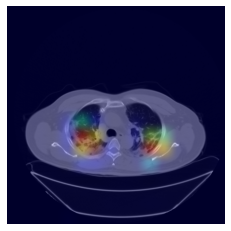

I210
Covid-19
1.0


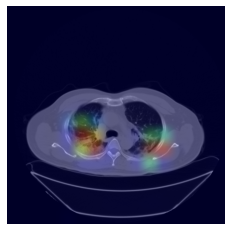

I220
Covid-19
1.0


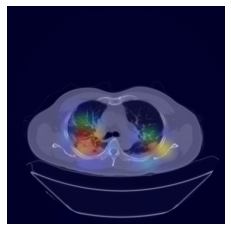

I230
Covid-19
1.0


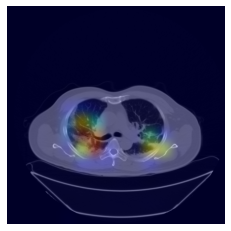

I240
Covid-19
1.0


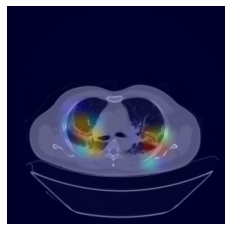

I250
Covid-19
1.0


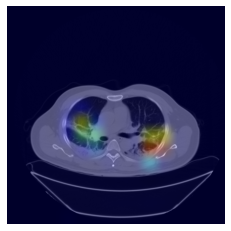

I260
Covid-19
1.0


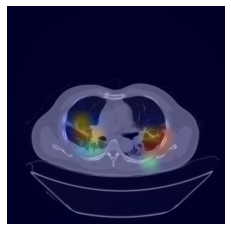

I270
Covid-19
0.9999962


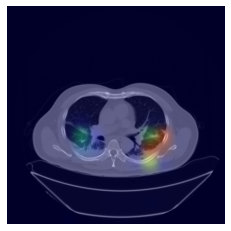

I280
Covid-19
0.9999993


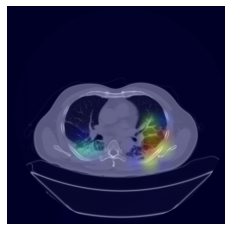

I290
Covid-19
0.99999213


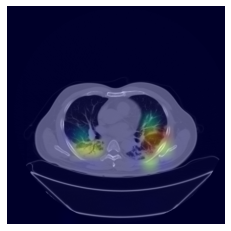

I300
Covid-19
0.9999993


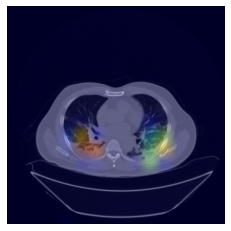

I320
Covid-19
1.0


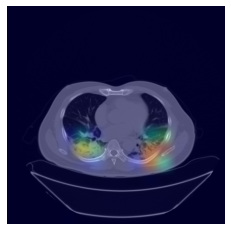

I330
Covid-19
1.0


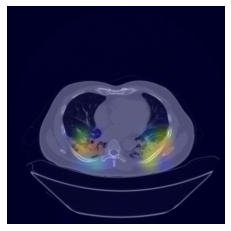

I340
Covid-19
1.0


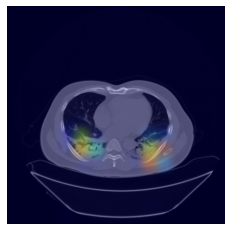

I350
Covid-19
0.99999976


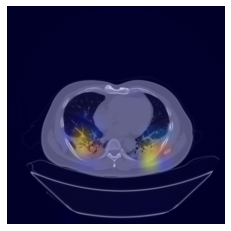

I360
Covid-19
1.0


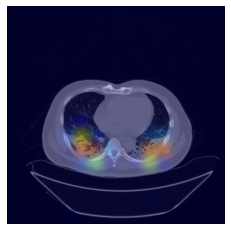

I370
Covid-19
1.0


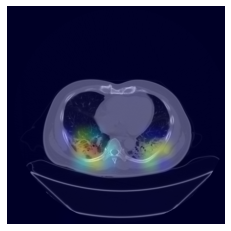



SUMMARY:
CT Scan terdiri dari 62 slices.
Daerah paru-paru yang dapat diobservasi (open lungs) berjumlah 17 slices.
Model klasifikasi memprediksi bahwa CT scan mengarah ke Covid-19.
Jumlah slices yang terindikasi Covid-19: 17.
Jumlah slices yang terindikasi Normal: 0.
Rata-rata probabilitas slices yang terindikasi Covid-19: 0.9999992.
Rata-rata probabilitas slices yang terindikasi Normal: 0.0000000.



In [ ]:
open_lungs_out = select_open_lungs(sorted_dicom_files)
imgs_array = open_lungs_out['imgs_array']
pred_out = predict(imgs_array)
gradcam_out = create_gradcam(net, imgs_array)


# Show output
covid_conf = []
normal_conf = []
for name, img in gradcam_out.items():
    info = pred_out['pred_img_info'][name]
    label = info['label']
    conf = info['conf']
    print(name)
    print(label)
    print(conf)
    if label == 'Covid-19':
      covid_conf.append(conf)
    else:
      normal_conf.append(conf)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

avg_normal_conf = sum(normal_conf) / (len(normal_conf) or not len(normal_conf))
avg_covid_conf = sum(covid_conf) / (len(covid_conf) or not len(covid_conf))


print(('\n\nSUMMARY:\nCT Scan terdiri dari {:d} slices.\n' + 
       'Daerah paru-paru yang dapat diobservasi (open lungs) berjumlah {:d} slices.\n' +
       'Model klasifikasi memprediksi bahwa CT scan mengarah ke {:s}.\n' +
       'Jumlah slices yang terindikasi Covid-19: {:d}.\n' +
       'Jumlah slices yang terindikasi Normal: {:d}.\n' +
       'Rata-rata probabilitas slices yang terindikasi Covid-19: {:1.7f}.\n' +
       'Rata-rata probabilitas slices yang terindikasi Normal: {:1.7f}.\n').format(
           open_lungs_out['num_all_imgs'],
           open_lungs_out['num_selected_imgs'],
           pred_out['class'],
           pred_out['num_covid_slices'],
           pred_out['num_normal_slices'],
           avg_covid_conf,
           avg_normal_conf))